In [1]:
import numpy as np

### S1

#### Load dataset

In [2]:
train_s1=np.load('/data/DW/Challenge/GermanAIChallenge2018/train_s1.npy')

train_s1.shape

(352366, 32, 32, 8)

In [3]:
valid_s1=np.load('/data/DW/Challenge/GermanAIChallenge2018/valid_s1.npy')

valid_s1.shape

(24119, 32, 32, 8)

In [3]:
R2testb_s1=np.load("/data/DW/Challenge/GermanAIChallenge2018/Round_2/R2testb_s1.npy")

R2testb_s1.shape

(4835, 32, 32, 8)

In [4]:
# concancate
# all_s1=np.concatenate((train_s1,valid_s1,R2testa_s1),axis=0)

# print(all_s1.shape)

# del train_s1,valid_s1,R2testa_s1

all_s1=R2testb_s1
print(all_s1.shape)

(4835, 32, 32, 8)


#### Generate intensity

In [5]:
#intensity
all_s1_first4=all_s1[:,:,:,:4]
#Covar-Mat
all_s1_second4=all_s1[:,:,:,4:]

del all_s1

print(all_s1_first4.shape,all_s1_second4.shape)

(4835, 32, 32, 4) (4835, 32, 32, 4)


##### log
$$x'=C\cdot\log\left(|x|+1\right)$$

In [6]:
all_s1_first4_log=np.log(np.abs(all_s1_first4)+1)

del all_s1_first4

In [7]:
all_s1_first4_gau=all_s1_first4_log

##### Gaussian Filter

$$x''=x'*G$$

In [8]:
import numpy as np
import scipy.misc
import scipy.signal
from tqdm import tqdm

# 概率密度函数
def get_cv(r, sigma):
    return 1 / (2 * np.pi * sigma ** 2) * np.exp((-r**2) / (2 * sigma ** 2))

# 高斯滤波掩模
def get_window():
    # 模糊半径为 2, sigma 为 1.5
    radius, sigma = 2, 1.5
    window = np.zeros((radius * 2 + 1, radius * 2 + 1))
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            r = (i ** 2 + j ** 2) ** 0.5
            window[i + radius][j + radius] = get_cv(r, sigma)
    return window / np.sum(window)

def convert_2d(r):
    window = get_window()
    s = scipy.signal.convolve2d(r, window, mode='same', boundary='symm')
    return s.astype(np.float)

def convert_3d(r):
    s_dsplit = []
    for d in range(r.shape[2]):
        rr = r[:, :, d]
        ss = convert_2d(rr)
        s_dsplit.append(ss)
    s = np.dstack(s_dsplit)
    return s

In [9]:

for i in tqdm(range(all_s1_first4_log.shape[0])):
    all_s1_first4_gau[[i],:,:,:] = convert_3d(all_s1_first4_log[i,:,:,:])[np.newaxis,:,:,:]

100%|██████████| 4835/4835 [00:05<00:00, 853.94it/s] 


##### VH & VV  
$$S^2=R^2+I^2$$

In [10]:
VH=np.sqrt(all_s1_first4_gau[:,:,:,[0]]**2+all_s1_first4_gau[:,:,:,[1]]**2)
print(VH.shape)

VV=np.sqrt(all_s1_first4_gau[:,:,:,[2]]**2+all_s1_first4_gau[:,:,:,[3]]**2)
print(VV.shape)

(4835, 32, 32, 1)
(4835, 32, 32, 1)


##### Merge

In [11]:
all_s1_first4_new=np.concatenate((VH,VV),axis=3)
all_s1_first4_new.shape

del all_s1_first4_log,all_s1_first4_gau,VH,VV

In [12]:
all_s1_first4_new.shape

(4835, 32, 32, 2)

#### Covariance Matrix

##### Production
$$
\begin{equation}
C=
\left[
    \begin{array}{ccc}
      0 & 0 & 0 \\
      0 & 2|S_{VH}|^2 & \sqrt{2}S_{VH}S_{VV} \\
      0 & \sqrt{2}S_{VH}S_{VV} & |S_{VV}|^2 \\
    \end{array}
\right]
\end{equation}
$$

In [13]:
all_s1_second4_off_diag=np.sqrt(all_s1_second4[:,:,:,[2]]**2+all_s1_second4[:,:,:,[3]]**2)
all_s1_second4_off_diag.shape

(4835, 32, 32, 1)

In [14]:
print(np.max(all_s1_second4),np.min(all_s1_second4))

1740.7296142578125 -638.33935546875


##### Freeman-Durden decomposition

In [15]:
#https://blog.csdn.net/peng_peng123/article/details/50476084 

#A=(1/sqrt(2))*[1 0 1;1 0 -1;0 sqrt(2) 0];    #相干矩阵[T]和协方差矩阵的转化系数
freem=np.zeros([all_s1_second4.shape[0],all_s1_second4.shape[1],all_s1_second4.shape[2],3])
for ii in tqdm(range(all_s1_second4.shape[0])):
    #t=[t11(ii,jj) t12(ii,jj) t13(ii,jj);t12(ii,jj)' t22(ii,jj) t23(ii,jj);t13(ii,jj)' t23(ii,jj)' t33(ii,jj)];
    #c=inv(A)*t*inv(A')##得到协方差矩阵
    C22=2*all_s1_second4[ii,:,:,0]
    C33=all_s1_second4[ii,:,:,1]
    C23=all_s1_second4_off_diag[ii,:,:0]
    fv=(3/2)*C22
    pv=(8/3)*fv #求pv
    #if real(c(1,3))>=0:
    alph=-1
    beta=1+(0-C33)/(0+C33-2*C22)
    beta[0+C33-2*C22 == 0] = 0
    # be=(c(1,1)+c(1,3)-2*c(2,2))/(c(1,3)+c(3,3)-2*c(2,2));
    ##求ps和pd
    fs = (0 + C33 - 2*C22)/(1 + beta)
    fs[1 + beta == 0] = 0
    ps=fs*(1+(np.abs(beta))**2)
    fd=C33-fs-fv
    pd=2*fd
##得到Pv、Ps、Pd三个分量
    freem[ii,:,:,0]=pd
    freem[ii,:,:,1]=pv
    freem[ii,:,:,2]=ps
    
print(freem.shape)

100%|██████████| 4835/4835 [00:00<00:00, 7620.73it/s]

(4835, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


606.6053440320276 -606.4738767194533


/home/sigma_wd/anaconda3/envs/pytorch/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


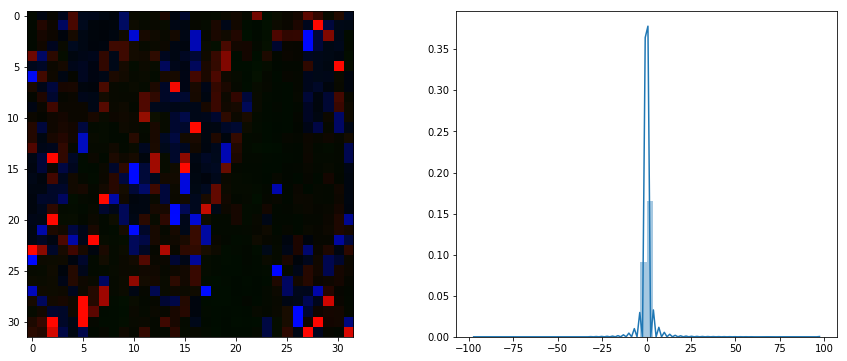

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))

print(np.max(freem[66,:,:,:]),np.min(freem[66,:,:,:]))
plt.figure(1,figsize=(15,6))

plt.subplot(1,2,1)
plt.imshow(freem[999,:,:,:])

import seaborn as sns

plt.subplot(1,2,2)
sns.distplot(freem[999,:,:,:].flatten())

##### log

In [17]:
freem_log=np.log(np.abs(freem)+1)

#####  Gaussian Filter

In [18]:
freem_gau=freem

for i in tqdm(range(freem.shape[0])):
    freem_gau[[i],:,:,:] = convert_3d(freem_log[i,:,:,:])[np.newaxis,:,:,:]

100%|██████████| 4835/4835 [00:03<00:00, 1275.16it/s]


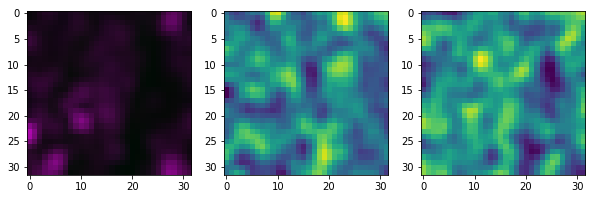

In [19]:
plt.figure(2,figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(freem_gau[999])
plt.subplot(1,3,2)
plt.imshow(all_s1_first4_new[999,:,:,0])
plt.subplot(1,3,3)
plt.imshow(all_s1_first4_new[999,:,:,1])

#### Concancate & Split

In [20]:
all_s1_new=np.concatenate((all_s1_first4_new,freem_gau),axis=3)

print(all_s1_new.shape)

del all_s1_second4,all_s1_second4_off_diag
del freem,freem_log,freem_gau
del all_s1_first4_new

(4835, 32, 32, 5)


split

In [22]:
#trn+val
# all_s1_new_trn=all_s1_new[:-4842,:,:,:]
# #tes
# all_s1_new_tes=all_s1_new[-4842:,:,:,:]

# del all_s1_new

# print(all_s1_new_trn.shape,all_s1_new_tes.shape)

(376485, 32, 32, 5) (4842, 32, 32, 5)


#### Standardization & Normalization

$$X'=\frac{X-\mu}{\sigma},X''=(y_2-y_1)\frac{X'-\min{X'}}{\max{X'}-\min{X'}}+y_1$$

In [21]:
# from sklearn.preprocessing import StandardScaler

# sta_scaler1 = StandardScaler()
# sta_scaler1.fit(all_s1_new_trn.reshape(-1,5))

# #mean
# sta_mean1=np.mean(all_s1_new_trn.reshape(-1,5),axis=0)
# print(sta_mean1)
# print(sta_scaler1.mean_)
sta_mean1=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/std_mean1.npy')
# #std
# sta_std1=np.std(all_s1_new_trn.reshape(-1,5),axis=0)
# print(sta_std1)
# print(sta_std1**2)
# print(sta_scaler1.var_)
sta_std1=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/std_std1.npy',)

# all_s1_new_trn_sta=sta_scaler1.transform(all_s1_new_trn.reshape(-1,5)).reshape(all_s1_new_trn.shape)
# all_s1_new_tes_sta=sta_scaler1.transform(all_s1_new_tes.reshape(-1,5)).reshape(all_s1_new_tes.shape)

# del all_s1_new_trn,all_s1_new_tes

testb_temp=all_s1_new.reshape(-1,5)

all_s1_new_sta=(testb_temp-sta_mean1)/sta_std1

all_s1_new_sta.shape

(4951040, 5)

In [23]:
# from sklearn.preprocessing import MinMaxScaler

# min_scaler1 = MinMaxScaler(feature_range=(-1,1))
# min_scaler1.fit(all_s1_new_trn_sta.reshape(-1,5))

# #min
# min_min1=np.min(all_s1_new_trn_sta.reshape(-1,5),axis=0)
# print(min_min1)
# print(min_scaler1.data_min_)
min_min1=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/min_min1.npy')

#max
# min_max1=np.max(all_s1_new_trn_sta.reshape(-1,5),axis=0)
# print(min_max1)
# print(min_scaler1.data_max_)
min_max1=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/min_max1.npy')

# all_s1_new_trn_sta_min=min_scaler1.transform(all_s1_new_trn_sta.reshape(-1,5)).reshape(all_s1_new_trn_sta.shape)
# all_s1_new_tes_sta_min=min_scaler1.transform(all_s1_new_tes_sta.reshape(-1,5)).reshape(all_s1_new_tes_sta.shape)

all_s1_new_sta_min=2*(all_s1_new_sta-min_min1)/(min_max1-min_min1)-1

all_s1_new_sta_min.shape

(4951040, 5)

In [24]:
R2testb_s1_new=all_s1_new_sta_min.reshape(all_s1_new.shape)
R2testb_s1_new.shape

(4835, 32, 32, 5)

#### Save

In [26]:
# #trn
# np.save('/data/DW/Challenge/GermanAIChallenge2018/R2trn_s1_new.npy',all_s1_new_trn_sta_min)
# #tes
# np.save('/data/DW/Challenge/GermanAIChallenge2018/R2tesa_s1_new.npy',all_s1_new_tes_sta_min)

np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/R2tesb_s1_new.npy',R2testb_s1_new)

In [124]:
del all_s1_new_tes_sta,all_s1_new_tes_sta_min
del all_s1_new_trn_sta,all_s1_new_trn_sta_min

### S2

#### Load dataset

In [3]:
train_s2=np.load('/data/DW/Challenge/GermanAIChallenge2018/train_s2.npy')

train_s2.shape

(352366, 32, 32, 10)

In [4]:
valid_s2=np.load('/data/DW/Challenge/GermanAIChallenge2018/valid_s2.npy')

valid_s2.shape

(24119, 32, 32, 10)

In [2]:
R2testb_s2=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/R2testb_s2.npy')

R2testb_s2.shape

(4835, 32, 32, 10)

In [3]:
# concancate
# all_s2=np.concatenate((train_s2,valid_s2,R2testa_s2),axis=0)

# print(all_s2.shape)

# del train_s2,valid_s2,R2testa_s2

all_s2=R2testb_s2

print(all_s2.shape)

(4835, 32, 32, 10)


#### Dehaze

In [5]:
#https://www.jianshu.com/p/df9c963a392a
import cv2  
import numpy as np
   
def zmMinFilterGray(src, r=5):  
    '''''最小值滤波，r是滤波器半径'''  
    return cv2.erode(src,np.ones((2*r-1,2*r-1)))
# =============================================================================
#     if r <= 0:  
#         return src  
#     h, w = src.shape[:2]  
#     I = src  
#     res = np.minimum(I  , I[[0]+range(h-1)  , :])  
#     res = np.minimum(res, I[range(1,h)+[h-1], :])  
#     I = res  
#     res = np.minimum(I  , I[:, [0]+range(w-1)])  
#     res = np.minimum(res, I[:, range(1,w)+[w-1]])  
# =============================================================================
 #   return zmMinFilterGray(res, r-1)  
    
def guidedfilter(I, p, r, eps):  
    '''''引导滤波，直接参考网上的matlab代码'''  
    height, width = I.shape  
    m_I = cv2.boxFilter(I, -1, (r,r))  
    m_p = cv2.boxFilter(p, -1, (r,r))  
    m_Ip = cv2.boxFilter(I*p, -1, (r,r))  
    cov_Ip = m_Ip-m_I*m_p  
   
    m_II = cv2.boxFilter(I*I, -1, (r,r))  
    var_I = m_II-m_I*m_I  
   
    a = cov_Ip/(var_I+eps)  
    b = m_p-a*m_I  
   
    m_a = cv2.boxFilter(a, -1, (r,r))  
    m_b = cv2.boxFilter(b, -1, (r,r))  
    return m_a*I+m_b  
   
def getV1(m, r, eps, w, maxV1):  #输入rgb图像，值范围[0,1]  
    '''''计算大气遮罩图像V1和光照值A, V1 = 1-t/A'''  
    V1 = np.min(m,2)                                         #得到暗通道图像  
    V1 = guidedfilter(V1, zmMinFilterGray(V1,5), r, eps)     #使用引导滤波优化  
    bins = 2000  
    ht = np.histogram(V1, bins)                              #计算大气光照A  
    d = np.cumsum(ht[0])/float(V1.size)  
    for lmax in range(bins-1, 0, -1):  
        if d[lmax]<=0.999:  
            break  
    A  = np.mean(m,2)[V1>=ht[1][lmax]].max()  
           
    V1 = np.minimum(V1*w, maxV1)                   #对值范围进行限制  
       
    return V1,A  
   
def deHaze(m, r=9, eps=0.001, w=0.95, maxV1=0.80, bGamma=False):  
    Y = np.zeros(m.shape)  
    V1,A = getV1(m, r, eps, w, maxV1)               #得到遮罩图像和大气光照  
    for k in range(m.shape[2]):  
        Y[:,:,k] = (m[:,:,k]-V1)/(1-V1/A)           #颜色校正  
    Y =  np.clip(Y, 1e-7, 1)
    if bGamma:  
        Y = Y**(np.log(0.5)/np.log(Y.mean()))       #gamma校正,默认不进行该操作  
    return Y  

In [6]:
all_s2_dehaze=all_s2.copy()
from tqdm import tqdm

for i in tqdm(range(all_s2.shape[0])):
    all_s2_dehaze[[i],:,:,:] = deHaze(all_s2[i,:,:,:])[np.newaxis,:,:,:]

100%|██████████| 4835/4835 [00:03<00:00, 1393.43it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


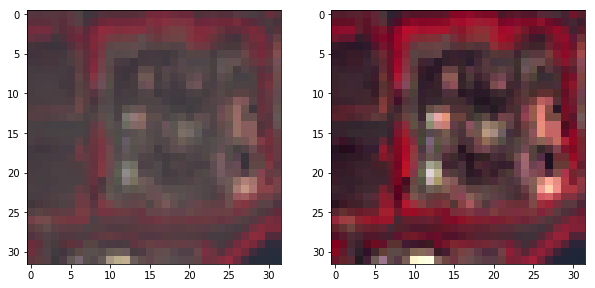

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1,figsize=(10,5))
plt.subplot(1,2,1)
aaa=all_s2[99][:,:,[6,2,1]]
print(aaa.shape)
plt.imshow(aaa*2)
plt.subplot(1,2,2)
bbb=all_s2_dehaze[99][:,:,[6,2,1]]
plt.imshow(bbb*2)

#### NDVI & NDWI

$$NDVI=\frac{NIR-R}{NIR+R},NDWI=\frac{G-NIR}{G+NIR}$$

In [4]:
# from sklearn.decomposition import PCA

# pca_model=PCA(n_components=1)
# all_s2_pca=pca_model.fit_transform(all_s2.reshape(-1,10)).reshape([all_s2.shape[0],all_s2.shape[1],all_s2.shape[2],1])
# print(all_s2.shape)

all_s2_dehaze=all_s2

all_s2_ndvi=(all_s2_dehaze[:,:,:,[6]]-all_s2_dehaze[:,:,:,[2]])/(all_s2_dehaze[:,:,:,[6]]+all_s2_dehaze[:,:,:,[2]])#(N,32,32,1)
all_s2_ndwi=(all_s2_dehaze[:,:,:,[1]]-all_s2_dehaze[:,:,:,[6]])/(all_s2_dehaze[:,:,:,[1]]+all_s2_dehaze[:,:,:,[6]])#(N,32,32,1)

In [11]:
del all_s2

#### Concancate & Gaussian_Filter

In [5]:
all_s2_con=np.concatenate((all_s2_dehaze,all_s2_ndvi,all_s2_ndwi),axis=3)

all_s2_con.shape

(4835, 32, 32, 12)

In [14]:
del all_s2_dehaze,all_s2_ndvi,all_s2_ndwi

In [10]:
# all_s2_con_gau=all_s2_con
# for i in tqdm(range(all_s2_con.shape[0])):
#     all_s2_con_gau[[i],:,:,:] = convert_3d(all_s2_con[i,:,:,:])[np.newaxis,:,:,:]

100%|██████████| 381327/381327 [25:21<00:00, 250.68it/s]


**split**

In [6]:
#trn+val
# all_s2_new_trn=all_s2_con[:-4842,:,:,:]
# #tes
# all_s2_new_tes=all_s2_con[-4842:,:,:,:]

# del all_s2_con

# print(all_s2_new_trn.shape,all_s2_new_tes.shape)

all_s2_new=all_s2_con

all_s2_new.shape

(4835, 32, 32, 12)

#### Standardization & Normalization

$$X'=\frac{X-\mu}{\sigma},X''=(y_2-y_1)\frac{X'-\min{X'}}{\max{X'}-\min{X'}}+y_1$$

###### TMD,MEMORY ERROR!

In [16]:
# #trn
# np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_trn.npy',all_s2_new_trn)
# #tes
# np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_tes.npy',all_s2_new_tes)

In [17]:
# #trn
# all_s2_new_trn=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_trn.npy')
# #tes
# all_s2_new_tes=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_tes.npy')

In [18]:
# temp_trn=all_s2_new_trn.reshape(-1,12)
# #trn_mean
# sta_mean2=np.mean(temp_trn,axis=0)
# np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/sta_mean2.npy',sta_mean2)
# #tes_std
# sta_std2=np.std(temp_trn,axis=0)
# np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/sta_std2.npy',sta_std2)

# print(sta_mean2)
# print(sta_std2)

[ 0.09859235  0.07835379  0.07087126  0.09091966  0.15787714  0.19181336
  0.18057296  0.21328782  0.16232975  0.09085526  0.36926505 -0.2859445 ]
[0.04515202 0.04706159 0.07051227 0.06336596 0.08825603 0.10965589
 0.11205073 0.12549632 0.12682652 0.10181612 0.41540645 0.41227002]


In [7]:
# from sklearn.preprocessing import StandardScaler

# sta_scaler2 = StandardScaler()


# sta_mean2=np.mean(temp_trn,axis=0)
# sta_std2=np.std(temp_trn,axis=0)

#trn_mean
sta_mean2=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/sta_mean2_haze.npy')
print(sta_mean2)
#trn_std
sta_std2=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/sta_std2_haze.npy')
print(sta_std2)

# temp_trn1=all_s2_new_trn[:200000].reshape(-1,12)
# all_s2_new_trn1_sta=(temp_trn1-sta_mean2)/sta_std2
# np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_trn1_sta.npy',all_s2_new_trn1_sta)
# del temp_trn1,all_s2_new_trn1_sta

# temp_trn2=all_s2_new_trn[200000:300000,:].reshape(-1,12)
# all_s2_new_trn2_sta=(temp_trn2-sta_mean2)/sta_std2
# np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_trn2_sta.npy',all_s2_new_trn2_sta)
# del temp_trn2,all_s2_new_trn2_sta

# temp_trn3=all_s2_new_trn[300000:,:].reshape(-1,12)

# all_s2_new_trn3_sta=(temp_trn3-sta_mean2)/sta_std2
# np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_trn3_sta.npy',all_s2_new_trn3_sta)
# del temp_trn3,all_s2_new_trn3_sta

temp_tesb=all_s2_new.reshape(-1,12)
all_s2_new_tes_sta=(temp_tesb-sta_mean2)/sta_std2
# np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_tes_sta.npy',all_s2_new_tes_sta)
# del temp_tes,all_s2_new_tes_sta

all_s2_new_tes_sta.shape

[ 0.12409098  0.10973338  0.10179375  0.11486063  0.1596039   0.18177358
  0.17486011  0.19535037  0.15552057  0.11024101  0.21897086 -0.15469921]
[0.03953144 0.0475408  0.06594696 0.06310347 0.07668508 0.09012078
 0.09137111 0.1006924  0.09965389 0.08769716 0.30272428 0.30932739]


(4951040, 12)

In [20]:
del all_s2_new_trn,all_s2_new_tes

In [2]:
# all_s2_new_trn1_sta=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_trn1_sta.npy')

# all_s2_new_trn2_sta=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_trn2_sta.npy')

# all_s2_new_trn3_sta=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_trn3_sta.npy')

# all_s2_new_tes_sta=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/all_s2_new_tes_sta.npy')

Normalization[-1,1]

In [3]:
# all_s2_new_trn_sta=np.concatenate((all_s2_new_trn1_sta,all_s2_new_trn2_sta,all_s2_new_trn3_sta),axis=0)

# del all_s2_new_trn1_sta,all_s2_new_trn2_sta,all_s2_new_trn3_sta

In [8]:
# min_min2=np.min(all_s2_new_trn_sta,axis=0)

# min_max2=np.max(all_s2_new_trn_sta,axis=0)

min_min2=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/min_min2_haze.npy')

min_max2=np.load('/data/DW/Challenge/GermanAIChallenge2018/Round_2/min_max2_haze.npy')

print(min_min2)
print(min_max2)

#transform
# all_s2_new_trn_sta_min=2*(all_s2_new_trn_sta-min_min2)/(min_max2-min_min2)-1

# del all_s2_new_trn_sta

all_s2_new_tes_sta_min=2*(all_s2_new_tes_sta-min_min2)/(min_max2-min_min2)-1

# del all_s2_new_tes_sta

all_s2_new_tes_sta_min.shape

[-3.13651544 -2.3060903  -1.54205379 -1.81861053 -2.07998593 -2.01589001
 -1.91264078 -1.93907753 -1.5596037  -1.25592448 -4.02617783 -2.73229146]
[67.69065061 56.5885835  40.91479585 42.55296149 34.43428579 29.05574573
 28.73161857 25.87235572 26.53764396 30.67099356  2.57955221  3.73090546]


(4951040, 12)

In [9]:
R2testb_s2_new=all_s2_new_tes_sta_min.reshape(all_s2_new.shape)
R2testb_s2_new.shape

(4835, 32, 32, 12)

#### save

In [10]:
# np.save('/data/DW/Challenge/GermanAIChallenge2018/R2trn_s2_new.npy',all_s2_new_trn_sta_min.reshape([376485, 32, 32, 12]))

np.save('/data/DW/Challenge/GermanAIChallenge2018/Round_2/R2tesb_s2_new_haze.npy',R2testb_s2_new)